# IOOS Environment Test 01

Before running this notebook, see the [instructions for setting up the IOOS Python Environment](
https://github.com/ioos/conda-recipes/wiki/Setting-up-the-IOOS-Python-environment-for-Linux)

In [1]:
import iris
import pytz
from datetime import datetime, timedelta

from utilities import CF_names

stop = datetime(2014, 7, 7, 12)
stop = stop.replace(tzinfo=pytz.utc)
start = stop - timedelta(days=7)

bbox = [-87.40, 24.25, -74.70, 36.70]

name_list = CF_names['sea_water_temperature']

units = iris.unit.Unit('celsius')

In [2]:
import warnings
from oceans import wrap_lon180
from utilities import quick_load_cubes, proc_cube, get_surface

# Changed to HYCOM because windows iris bombs with Memory error for big data.
#url = "http://oos.soest.hawaii.edu/thredds/dodsC/pacioos/hycom/global"
url = "http://ecowatch.ncddc.noaa.gov/thredds/dodsC/hycom/hycom_reg1_agg/HYCOM_Region_1_Aggregation_best.ncd"

with warnings.catch_warnings():
    warnings.simplefilter("ignore")  # Suppress iris warnings.
    cube = quick_load_cubes(url, name_list, callback=None, strict=True)

In [3]:
cube

<iris 'Cube' of sea_water_temperature / (degC) (time: 5611; depth: 40; latitude: 876; longitude: 626)>

In [4]:
cube.coord(axis='X').points[:20]

array([ 260.00003052,  260.08004761,  260.16003418,  260.24002075,
        260.32003784,  260.40002441,  260.48001099,  260.56002808,
        260.64004517,  260.72003174,  260.80004883,  260.8800354 ,
        260.96002197,  261.04003906,  261.12002563,  261.20004272,
        261.2800293 ,  261.36001587,  261.44003296,  261.52001953])

In [5]:
# Just found a bug in proc_cube().  Meanwhile lets skip the constraint step.
cube.coord(axis='X').points = wrap_lon180(cube.coord(axis='X').points)

In [6]:
cube.coord(axis='X').points[:20]

array([-99.99996948, -99.91995239, -99.83996582, -99.75997925,
       -99.67996216, -99.59997559, -99.51998901, -99.43997192,
       -99.35995483, -99.27996826, -99.19995117, -99.1199646 ,
       -99.03997803, -98.95996094, -98.87997437, -98.79995728,
       -98.7199707 , -98.63998413, -98.55996704, -98.47998047])

In [7]:
# cube = proc_cube(cube, bbox=bbox, time=(start, stop), units=units)
cube = get_surface(cube)  # Get a 2D surface cube.  I am working on 3D...
cube

<iris 'Cube' of sea_water_temperature / (degC) (time: 5611; latitude: 876; longitude: 626)>

In [8]:
from utilities import get_nearest_water, make_tree

obs = dict(lon=-77.7867, lat=34.2133)

tree, lon, lat = make_tree(cube)
kw = dict(k=10, max_dist=0.04, min_var=0.01)
series, dist, idx = get_nearest_water(cube, tree, obs['lon'], obs['lat'], **kw)

print('Distance (degrees): {}'.format(dist))
print('Indices: {!r}'.format(idx))

Distance (degrees): 0.0377726688863
Indices: (428, 278)


In [9]:
series

<iris 'Cube' of sea_water_temperature / (degC) (time: 5611)>

In [10]:
%matplotlib inline
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from cartopy.feature import NaturalEarthFeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

states = NaturalEarthFeature(category='cultural', scale='50m', facecolor='none',
                             name='admin_1_states_provinces_shp')

def make_map(projection=ccrs.PlateCarree()):
    fig, ax = plt.subplots(figsize=(8, 6),
                           subplot_kw=dict(projection=projection))
    ax.coastlines(resolution='50m')
    gl = ax.gridlines(draw_labels=True)
    gl.xlabels_top = gl.ylabels_right = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    return fig, ax

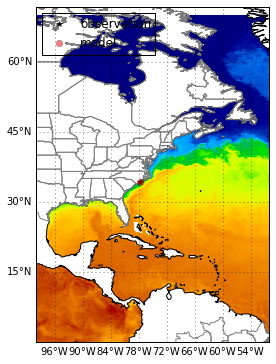

In [11]:
import numpy.ma as ma
from oceans import cm


c = cube[0, ...]
c.data = ma.masked_invalid(c.data)
# I hate when I have to "mask manually."
c.data = ma.masked_greater(c.data, 999)

lon = c.coord(axis='X').points
lat = c.coord(axis='Y').points

extent = (lon.min(), lon.max(),
          lat.min(), lat.max())

fig, ax = make_map()
ax.set_extent(extent)
cs = ax.pcolormesh(lon, lat, c.data, cmap=cm.rscolmap, alpha=0.5)
ax.plot(obs['lon'], obs['lat'], 'k*', label='observation')
# Note that to avoid dealing with the different indices formats
# from the different models (FVCOM, ROMS, ESTOFS etc)
# I recommend using the coords from the series output.
ax.plot(series.coord(axis='X').points,
        series.coord(axis='Y').points,
        'ro', label='model', alpha=0.5)
#ax.set_title(c.attributes['title'])
ax.add_feature(states, edgecolor='gray')
leg = ax.legend(numpoints=1, loc='upper left')

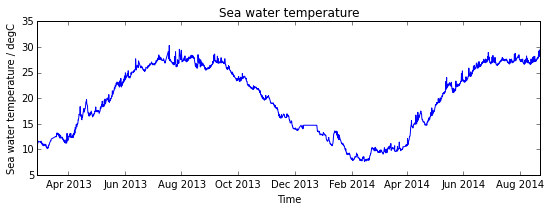

In [12]:
import iris.quickplot as qplt

# I hate when I have to "mask manually."
series.data = ma.masked_greater(series.data, 999)

fig, ax = plt.subplots(figsize=(9, 2.75))
l, = qplt.plot(series)

In [13]:
!conda info

Current conda install:

             platform : win-64
        conda version : 3.9.1
  conda-build version : 1.11.0
       python version : 2.7.7.final.0
     requests version : 2.5.3
     root environment : c:\programs\anaconda-64  (writable)
  default environment : c:\programs\anaconda-64
     envs directories : c:\programs\anaconda-64\envs
        package cache : c:\programs\anaconda-64\pkgs
         channel URLs : https://conda.binstar.org/ioos/win-64/
                        https://conda.binstar.org/ioos/noarch/
                        http://repo.continuum.io/pkgs/free/win-64/
                        http://repo.continuum.io/pkgs/free/noarch/
                        http://repo.continuum.io/pkgs/pro/win-64/
                        http://repo.continuum.io/pkgs/pro/noarch/
          config file : C:\Users\rsignell\.condarc
    is foreign system : False



In [14]:
!conda list

# packages in environment at c:\programs\anaconda-64:
#
_license                  1.1                      py27_0    <unknown>
anaconda                  2.0.1                np18py27_0    <unknown>
argcomplete               0.6.7                    py27_0    <unknown>
astropy                   0.3.2                np18py27_0    <unknown>
atom                      0.3.7                    py27_0    <unknown>
backports.ssl-match-hostname 3.4.0.2                   <pip>
beautiful-soup            4.3.1                    py27_0    <unknown>
beautifulsoup4            4.3.1                     <pip>
binstar                   0.10.1                   py27_2    defaults
bitarray                  0.8.1                    py27_1    <unknown>
blaze                     0.5.0                np18py27_1    <unknown>
blz                       0.6.2                np18py27_0    <unknown>
bokeh                     0.4.4                np18py27_1    <unknown>
boto                      2.28.0             